# Use Regression to define weights for each feature

In [76]:
from os import listdir
import numpy as np
from syntax_features import counts
from feature_extraction_V1 import get_text_features_V1
import pandas as pd
import codecs
import matplotlib.pyplot as plt

In [3]:
class TextScorer:    
    lsat_texts = None
    re_features_max = None
    pa_features_max = None
    
    def __init__(self):
        with open('data/LSATtexts.txt', 'r', encoding="utf8") as lsat_file:
            self.lsat_texts = lsat_file.read()
            self.lsat_texts = self.lsat_texts.split("\n\n")
            for text in self.lsat_texts:
                if text[0] == '#':
                    self.lsat_texts.remove(text)
        
        self.re_features_max = np.array(np.mean(counts(self.lsat_texts), axis=0))
        self.pa_features_max = np.array(get_text_features_V1("\n".join(self.lsat_texts)))
        
    
    def score(self, text):
        re_features = np.array(counts([text])).reshape(-1)
        pa_features = np.array(get_text_features_V1(text))
        return re_features / self.re_features_max, pa_features / self.pa_features_max
    
    def get_features(self, text):
        re_features = np.array(counts([text])).reshape(-1)
        pa_features = np.array(get_text_features_V1(text))
        return re_features / self.re_features_max, pa_features / self.pa_features_max

In [4]:
ts = TextScorer()

In [5]:
# counts:
re_feature_names = ["Subordination", "Complements", "Coordination", "Apposition", "Passive verbs", "Parataxis", "Auxiliary Verbs", "Negation", "Prepositional Phrases", "Modifiers"]
# get_text_features_V1
pa_feature_names = ["Mean word length", "Mean sentence length", "Basic english ratio", "Syllables per sentence", "Type token ratio", "#nouns", "#verbs", "#adjectives", "#adverbs", "#pronouns", "#commas"]


## Load Data and define Features

In [6]:
files = listdir("data/newsela/")
files_with_score = [np.concatenate(
    [[file],file.split(".")[0].split("-")]) for file in files if file.split(".")[1] == "txt"]
files_with_score[:5]

[array(['44452-1250.txt', '44452', '1250'], dtype='<U14'),
 array(['44089-660.txt', '44089', '660'], dtype='<U13'),
 array(['44271-1060.txt', '44271', '1060'], dtype='<U14'),
 array(['43993-810.txt', '43993', '810'], dtype='<U13'),
 array(['44384-850.txt', '44384', '850'], dtype='<U13')]

In [47]:
lines = []
for path,file_id,newsela_score in files_with_score:
    with codecs.open("data/newsela/"+path, "r",encoding='utf-8', errors='ignore') as f:
        score = np.concatenate(ts.score(f.read()))
        score[12] = 1 / score[12] #basic english
        #score[14] = 0 #ttr
        #print(np.concatenate([[file_id],score]))
        lines += [np.concatenate([[file_id,newsela_score],score])]
        
df = pd.DataFrame(
    data=lines,
    columns=np.concatenate([["text","newsela_score"],re_feature_names,pa_feature_names]))

In [48]:
df[df.columns[2:]] = df[df.columns[2:]].astype(float)

In [49]:
print(df.dtypes)
df.head()


text                       object
newsela_score              object
Subordination             float64
Complements               float64
Coordination              float64
Apposition                float64
Passive verbs             float64
Parataxis                 float64
Auxiliary Verbs           float64
Negation                  float64
Prepositional Phrases     float64
Modifiers                 float64
Mean word length          float64
Mean sentence length      float64
Basic english ratio       float64
Syllables per sentence    float64
Type token ratio          float64
#nouns                    float64
#verbs                    float64
#adjectives               float64
#adverbs                  float64
#pronouns                 float64
#commas                   float64
dtype: object


,text,newsela_score,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,...,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas
0,44452,1250,0.612571,0.941092,0.397031,2.102986,0.435028,1.143411,0.687679,0.492393,...,0.750172,0.469071,0.747502,2.089380,0.884943,0.835438,0.397092,0.659161,0.842966,0.609639
1,44089,660,0.173495,0.396478,0.295434,0.934660,0.478761,0.000000,0.282052,0.284494,...,0.416571,0.405701,0.374118,2.258870,0.544231,0.435264,0.263456,0.291552,0.457886,0.211489
2,44271,1060,0.272545,0.695125,0.443624,0.458833,0.646327,1.081043,0.553848,0.372428,...,0.614785,0.424630,0.575281,2.045101,0.621764,0.697873,0.669762,0.563112,0.435385,0.428899
3,43993,810,0.351327,0.860217,0.351914,0.262873,0.201977,0.000000,0.620822,0.640111,...,0.471443,0.387365,0.417188,2.279102,0.430455,0.678350,0.527425,0.506624,0.620614,0.347287
4,44384,850,0.312291,0.617075,0.131710,0.147578,0.170086,2.086224,0.290443,0.359361,...,0.469719,0.388829,0.417188,2.107943,0.570544,0.515196,0.401688,0.454554,0.415732,0.315666


In [50]:
df.to_csv("data/newsela/text_features.csv",sep=",")

## Plot Result

In [51]:
plot_df = df.loc[df["newsela_score"] != "max"]

In [52]:
plot_df["feature_sums"] = plot_df.drop(columns=["text","newsela_score"]).sum(axis=1)
plot_df["feature_sums"] = pd.to_numeric(plot_df["feature_sums"])

/Users/d062280/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/d062280/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [53]:
plot_df["newsela_score"] = pd.to_numeric(plot_df["newsela_score"])

/Users/d062280/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


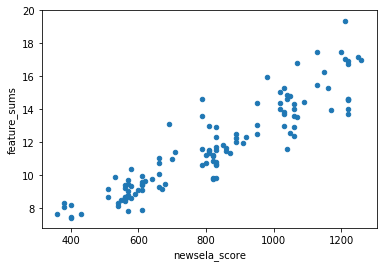

In [66]:
plot_df.plot.scatter(x="newsela_score",y="feature_sums")

## Apply Regression Model

### LogisticRegression

In [69]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [63]:
lg_model = linear_model.LogisticRegression()
lg_model.fit(plot_df[df.columns[2:]].values,plot_df["newsela_score"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [73]:
mean_squared_error(plot_df["newsela_score"].values,lg_model.predict(plot_df[plot_df.columns[2:-1]].values))

15105.0

### LassoCV

In [155]:
def train_eval_lasso(x_train,y_train,x_test,y_test):
    lasso = linear_model.LassoCV(normalize=True,)
    lasso.fit(x_train,y_train)
    
    print("Evaluation: \n Score: {} \n Feature Importance:".format(lasso.score(x_train,y_train)))
    for row in zip(*[x_train.columns,lasso.coef_]):
        print(row)
    
    print("Prediction: ")
    print(lasso.predict(x_test))
    print("Actual: ")
    print(y_test)

In [130]:
#test article
test_articles = []
for file_name,newsela_score in [("43643-1040.txt",1040),("43643-580.txt",580),("43643-800.txt",800)]:
    with codecs.open("data/newsela/test/"+file_name, "r",encoding='utf-8', errors='ignore') as f:
            score = np.concatenate(ts.score(f.read()))
            test_articles += [(score,newsela_score)]

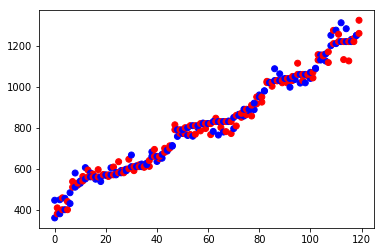

In [103]:
sorted_data = plot_df.sort_values("newsela_score",ascending=True)
X_sorted = sorted_data[plot_df.columns[2:-1]].values
y_sorted = sorted_data["newsela_score"]
predictions = lasso.predict(X_sorted)
plt.scatter(x=[range(len(plot_df)),range(len(plot_df))],y=[predictions,y_sorted],c=["blue","red"])

In [132]:
X_test,y_test = list(zip(*test_articles))

In [118]:
lasso.predict(X_test)

array([1330.28966803,  958.99127132, 1123.21887742])

In [119]:
y_test

(1040, 580, 800)

In [121]:
list(zip(*[plot_df.columns[2:-1],lasso.coef_]))

[('Subordination', 54.67384824381069),
 ('Complements', 4.138231316324232),
 ('Coordination', 0.0),
 ('Apposition', 0.0),
 ('Passive verbs', 0.0),
 ('Parataxis', 6.100970328115911),
 ('Auxiliary Verbs', 0.0),
 ('Negation', 0.0),
 ('Prepositional Phrases', 255.51975207398917),
 ('Modifiers', 17.17862341329988),
 ('Mean word length', 570.6252436943868),
 ('Mean sentence length', 1025.801559204219),
 ('Basic english ratio', 181.39328454728474),
 ('Syllables per sentence', 0.0),
 ('Type token ratio', 7.965613204164567),
 ('#nouns', 43.630327906080836),
 ('#verbs', 135.35395451461483),
 ('#adjectives', -0.0),
 ('#adverbs', 29.443281350249244),
 ('#pronouns', -40.32065283825201),
 ('#commas', 27.57260310767645)]

#### Train without verbs

In [170]:
def eval_exclude_cols(df,exclude,x_test,y_test):
    col_without = df.columns[2:-1]
    bool_without = col_without != exclude
    col_without = col_without[bool_without]
    
    x_train = df[col_without]
    y_train = df["newsela_score"]
    
    train_eval_lasso(
        x_train,y_train,x_test,y_test)

In [173]:
eval_exclude_cols(
    plot_df,
    "#verbs",
    [row[bool_without_verbs] for row in X_test],
    y_test
)

Evaluation: 
 Score: 0.976266070436005 
 Feature Importance:
('Subordination', 75.36387151978816)
('Complements', 21.82430791943597)
('Coordination', -0.0)
('Apposition', 0.0)
('Passive verbs', 0.0)
('Parataxis', 6.879708764298308)
('Auxiliary Verbs', 24.003204952105627)
('Negation', 0.0)
('Prepositional Phrases', 240.8344444354659)
('Modifiers', 0.0)
('Mean word length', 589.3993804176313)
('Mean sentence length', 1179.0390270989722)
('Basic english ratio', 188.55021064411653)
('Syllables per sentence', 0.0)
('Type token ratio', 10.862086223134593)
('#nouns', 0.0)
('#adjectives', -0.0)
('#adverbs', 22.417858515740715)
('#pronouns', -44.60272647543229)
('#commas', 20.975832294499394)
Prediction: 
[1340.6682353   972.83223372 1135.64879694]
Actual: 
(1040, 580, 800)


#### Train without Sentence length

In [174]:
eval_exclude_cols( 
    plot_df,
    "Mean sentence length",
    [row[bool_without_verbs] for row in X_test],
    y_test
)

Evaluation: 
 Score: 0.9722445709868963 
 Feature Importance:
('Subordination', 30.9155079130783)
('Complements', 0.0)
('Coordination', 0.0)
('Apposition', 0.0)
('Passive verbs', 0.0)
('Parataxis', 1.2951524279738185)
('Auxiliary Verbs', 0.0)
('Negation', 0.0)
('Prepositional Phrases', 270.24336611040326)
('Modifiers', 131.94934081607536)
('Mean word length', 283.1649943733357)
('Basic english ratio', 48.92238244450894)
('Syllables per sentence', 658.2685625824805)
('Type token ratio', 0.0)
('#nouns', 221.34523299217966)
('#verbs', 230.62792454910382)
('#adjectives', 0.0)
('#adverbs', 17.554415933393063)
('#pronouns', -0.0)
('#commas', 63.998397102274424)
Prediction: 
[2401.81131978 2302.88295517 2350.32360592]
Actual: 
(1040, 580, 800)
